# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

Below I've set up an outline of a notebook for this project, with some guidance and hints. If you're up for a real challenge, try doing this project from scratch in a new, clean notebook!


## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [4]:
import pandas as pd
masses_data = pd.read_csv("mammographic_masses.data.txt")
masses_data.head()

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0


Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [14]:
columns =['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']
masses_data = pd.read_csv("mammographic_masses.data.txt", na_values=['?'], names=columns)
masses_data.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [15]:
masses_data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [17]:
masses_data.loc[(masses_data['Age'].isnull()) | 
                (masses_data['Shape'].isnull()) |
                (masses_data['Margin'].isnull()) |
                (masses_data['Density'].isnull())]

,BI-RADS,Age,Shape,Margin,Density,Severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [20]:
masses_data.dropna(inplace=True)
masses_data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [ ]:
features = masses_data[['Age', 'Shape', 'Margin', 'Density']].values
print(features) #[67.  3.  5.  3.] [58.  4.  5.  3.] ...

labels = masses_data[['Severity']].values
print(labels) #[1] [0] [1] [1]...

feature_names = ['Age', 'Shape', 'Margin', 'Density'] #Saving for later use

Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [25]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(features)
print(scaled_features)

[[ 0.7650629   0.17563638  1.39618483  0.24046607]
 [ 0.15127063  0.98104077  1.39618483  0.24046607]
 [-1.89470363 -1.43517241 -1.157718    0.24046607]
 ...
 [ 0.56046548  0.98104077  1.39618483  0.24046607]
 [ 0.69686376  0.98104077  1.39618483  0.24046607]
 [ 0.42406719  0.17563638  0.11923341  0.24046607]]


## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [30]:
import numpy as np

np.random.seed(1234) #Consistent results

from sklearn.model_selection import train_test_split
(train_features, test_features, train_labels, test_labels) = train_test_split(scaled_features, labels, train_size=0.75, random_state=0)

Now create a DecisionTreeClassifier and fit it to your training data.

In [32]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=1)
clf.fit(train_features, train_labels)

DecisionTreeClassifier(random_state=1)

Display the resulting decision tree.

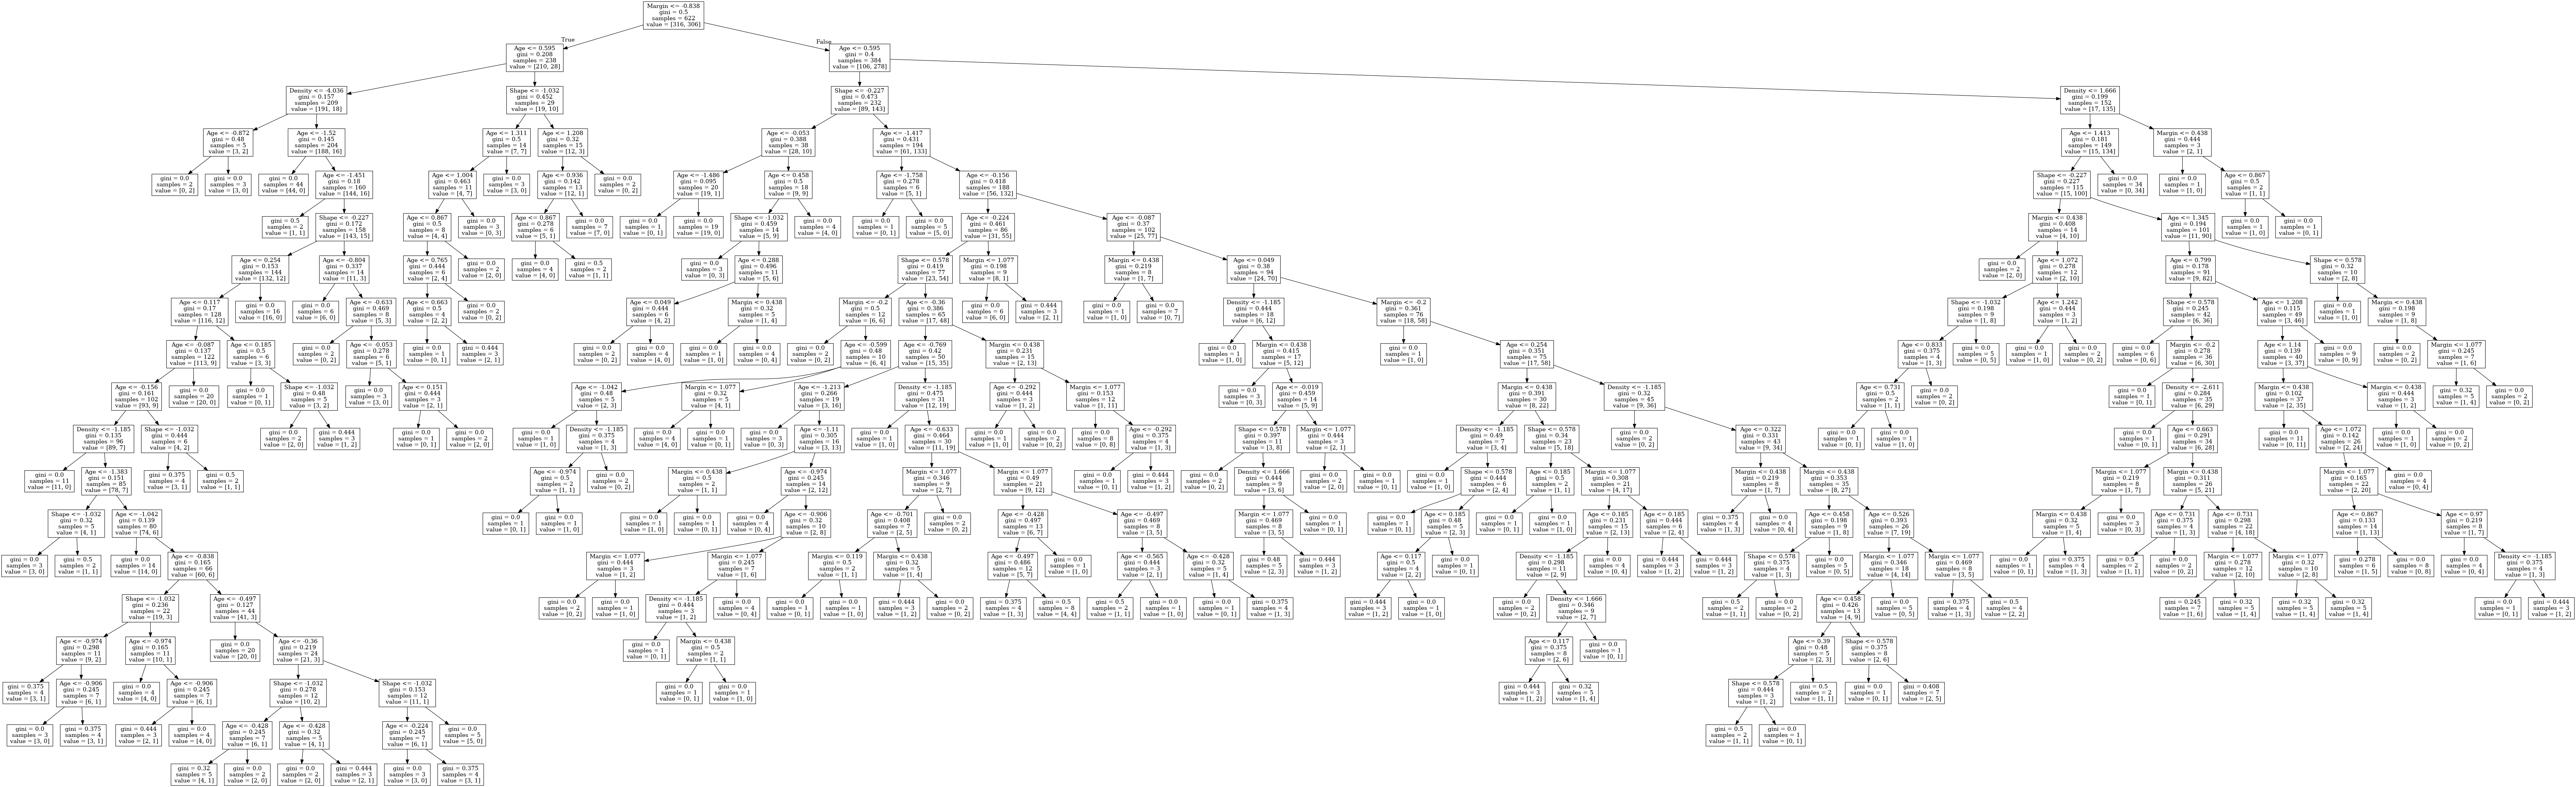

In [34]:
from IPython.display import Image  
from six import StringIO  
from sklearn import tree
from pydotplus import graph_from_dot_data 

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_names)  
graph = graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

Measure the accuracy of the resulting decision tree model using your test data.

In [35]:
clf.score(test_features, test_labels)

0.7163461538461539

Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [37]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, scaled_features, labels)

print(scores.mean())

0.7253012048192771


Now try a RandomForestClassifier instead. Does it perform better?

In [55]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, random_state=1)
scores = cross_val_score(clf, scaled_features, labels.ravel(), cv=10)

print(scores.mean())

0.7421686746987952


## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [43]:
from sklearn import svm

svc = svm.SVC(kernel='linear', C=1.0)


In [57]:
scores = cross_val_score(svc, scaled_features, labels.ravel(), cv=10)
scores.mean()


0.7975903614457832

## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [63]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(clf, scaled_features, labels.ravel(), cv=10)
scores.mean()



0.7915662650602409

Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [62]:
for i in range(1,50):
    clf = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(clf, scaled_features, labels.ravel(), cv=10)
    print(i + scores.mean())

1.7325301204819277
2.6903614457831324
3.7542168674698795
4.734939759036145
5.771084337349397
6.768674698795181
7.795180722891566
8.77710843373494
9.790361445783132
10.79156626506024
11.789156626506024
12.783132530120483
13.787951807228916
14.786746987951807
15.786746987951807
16.783132530120483
17.778313253012048
18.778313253012048
19.78433734939759
20.7855421686747
21.787951807228914
22.7855421686747
23.778313253012048
24.778313253012048
25.78674698795181
26.7855421686747
27.7855421686747
28.78674698795181
29.7855421686747
30.790361445783134
31.78674698795181
32.78915662650602
33.787951807228914
34.78674698795181
35.78313253012048
36.78674698795181
37.78433734939759
38.78674698795181
39.78192771084338
40.78433734939759
41.78072289156626
42.78192771084338
43.78072289156626
44.78192771084338
45.78313253012048
46.78433734939759
47.78915662650602
48.790361445783134
49.79156626506024


## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use MinMaxScaler to get the features in the range MultinomialNB requires.

In [66]:
from sklearn.naive_bayes import MultinomialNB

scaler = preprocessing.MinMaxScaler()
features_minmax = scaler.fit_transform(features)

clf = MultinomialNB()
scores = cross_val_score(clf, features_minmax, labels.ravel(), cv = 10)
print(scores.mean())

0.7855421686746988


## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [67]:
svc = svm.SVC(kernel='rbf', C=1.0)
scores = cross_val_score(svc, scaled_features, labels.ravel(), cv=10)
scores.mean()


0.8012048192771084

In [68]:
svc = svm.SVC(kernel='sigmoid', C=1.0)
scores = cross_val_score(svc, scaled_features, labels.ravel(), cv=10)
scores.mean()


0.7457831325301204

In [69]:
svc = svm.SVC(kernel='poly', C=1.0)
scores = cross_val_score(svc, scaled_features, labels.ravel(), cv=10)
scores.mean()


0.7903614457831326

## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [70]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
scores = cross_val_score(clf, scaled_features, labels.ravel(), cv=10)
scores.mean()

0.8072289156626505

## Neural Networks

As a bonus challenge, let's see if an artificial neural network can do even better. You can use Keras to set up a neural network with 1 binary output neuron and see how it performs. Don't be afraid to run a large number of epochs to train the model if necessary.

In [71]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential()
    model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
    return model

In [72]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

estimator = KerasClassifier(build_fn=create_model, epochs=100, verbose=2)
scores = cross_val_score(estimator, scaled_features, labels.ravel(), cv=10)
scores.mean()

2022-02-14 19:24:59.955406: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-14 19:24:59.957264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-14 19:24:59.960678: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-14 19:25:00.119244: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-14 19:25:00.148675: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2494215000 Hz


Epoch 1/100
24/24 - 1s - loss: 0.6910 - accuracy: 0.7564
Epoch 2/100
24/24 - 0s - loss: 0.6857 - accuracy: 0.7831
Epoch 3/100
24/24 - 0s - loss: 0.6756 - accuracy: 0.7805
Epoch 4/100
24/24 - 0s - loss: 0.6589 - accuracy: 0.7845
Epoch 5/100
24/24 - 0s - loss: 0.6348 - accuracy: 0.7952
Epoch 6/100
24/24 - 0s - loss: 0.6073 - accuracy: 0.7979
Epoch 7/100
24/24 - 0s - loss: 0.5798 - accuracy: 0.8059
Epoch 8/100
24/24 - 0s - loss: 0.5548 - accuracy: 0.8086
Epoch 9/100
24/24 - 0s - loss: 0.5335 - accuracy: 0.8126
Epoch 10/100
24/24 - 0s - loss: 0.5154 - accuracy: 0.8112
Epoch 11/100
24/24 - 0s - loss: 0.5010 - accuracy: 0.8099
Epoch 12/100
24/24 - 0s - loss: 0.4889 - accuracy: 0.8112
Epoch 13/100
24/24 - 0s - loss: 0.4790 - accuracy: 0.8112
Epoch 14/100
24/24 - 0s - loss: 0.4712 - accuracy: 0.8099
Epoch 15/100
24/24 - 0s - loss: 0.4648 - accuracy: 0.8099
Epoch 16/100
24/24 - 0s - loss: 0.4596 - accuracy: 0.8099
Epoch 17/100
24/24 - 0s - loss: 0.4552 - accuracy: 0.8099
Epoch 18/100
24/24 - 0s

0.8024096369743348

## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best? Feel free to share your results!